# Linear Regression Algorithms using Apache SystemML

This notebook shows:
- Install SystemML Python package and jar file
  - pip
  - SystemML 'Hello World'
- Example 1: Matrix Multiplication
  - SystemML script to generate a random matrix, perform matrix multiplication, and compute the sum of the output
  - Examine execution plans, and increase data size to obverve changed execution plans
- Load diabetes dataset from scikit-learn
- Example 2: Implement three different algorithms to train linear regression model
  - Algorithm 1: Linear Regression - Direct Solve (no regularization)
  - Algorithm 2: Linear Regression - Batch Gradient Descent (no regularization)
  - Algorithm 3: Linear Regression - Conjugate Gradient (no regularization)
- Example 3: Invoke existing SystemML algorithm script LinearRegDS.dml using MLContext API
- Example 4: Invoke existing SystemML algorithm using scikit-learn/SparkML pipeline like API
- Uninstall/Clean up SystemML Python package and jar file

# Install SystemML Python package and jar file

In [7]:
!pip uninstall systemml --y
!pip install --user https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz

Cannot uninstall requirement systemml, not installed
  HTTP error 404 while getting https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz
  Could not install requirement https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz because of error 404 Client Error: Not Found for url: https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz
Could not install requirement https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz because of HTTP error 404 Client Error: Not Found for url: https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz for UR

In [8]:
!pip show systemml

### Import SystemML API 

In [9]:
from pyspark import SparkContext
from systemml import MLContext, dml, dmlFromResource
sc = SparkContext("local", "Simple App")
ml = MLContext(sc)

print "Spark Version:", sc.version
print "SystemML Version:", ml.version()
print "SystemML Built-Time:", ml.buildTime()

ImportError: No module named systemml

In [6]:
ml.execute(dml("""s = 'Hello World!'""").output("s")).get("s")

SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	0.




u'Hello World!'

### Import numpy, sklearn, and define some helper functions

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
plt.switch_backend('agg')

/Users/jeromenilmeier/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Example 1: Matrix Multiplication

### SystemML script to generate a random matrix, perform matrix multiplication, and compute the sum of the output

In [8]:
script = """
    X = rand(rows=$nr, cols=1000, sparsity=0.5)
    A = t(X) %*% X
    s = sum(A)
"""

In [9]:
prog = dml(script).input('$nr', 1e5).output('s')
s = ml.execute(prog).get('s')
print (s)

[Stage 0:>                                                          (0 + 0) / 5]
[Stage 0:===========>                                               (1 + 1) / 5]
[Stage 0:=======================>                                   (2 + 1) / 5]
[Stage 0:===================================>                       (3 + 1) / 5]
[Stage 0:===============================================>           (4 + 1) / 5]
SystemML Statistics:
Total execution time:		5.065 sec.
Number of executed Spark inst:	2.

                                                                                

6259929615.13


# Load diabetes dataset from scikit-learn 

In [10]:
%matplotlib inline

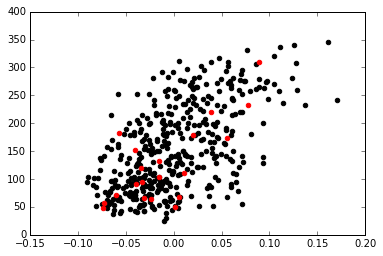

In [11]:
diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

In [12]:
diabetes.data.shape

(442, 10)

# Example 2: Implement three different algorithms to train linear regression model

## Algorithm 1: Linear Regression - Direct Solve (no regularization) 

#### Least squares formulation
w* = argminw ||Xw-y||2 = argminw (y - Xw)'(y - Xw) = argminw (w'(X'X)w - w'(X'y))/2

#### Setting the gradient
dw = (X'X)w - (X'y) to 0, w = (X'X)-1(X' y) = solve(X'X, X'y)

In [13]:
script = """
    # add constant feature to X to model intercept
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

In [14]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.040 sec.
Number of executed Spark inst:	2.




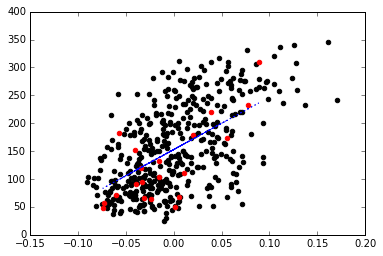

In [16]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue', linestyle ='dotted')

## Algorithm 2: Linear Regression - Batch Gradient Descent (no regularization)

#### Algorithm
`Step 1: Start with an initial point 
while(not converged) { 
  Step 2: Compute gradient dw. 
  Step 3: Compute stepsize alpha.     
  Step 4: Update: wnew = wold + alpha*dw 
}`

#### Gradient formula
`dw = r = (X'X)w - (X'y)`

#### Step size formula
`Find number alpha to minimize f(w + alpha*r) 
alpha = -(r'r)/(r'X'Xr)`

![Gradient Descent](http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png)

In [17]:
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = -(t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w + dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [18]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w', 'bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.066 sec.
Number of executed Spark inst:	2.




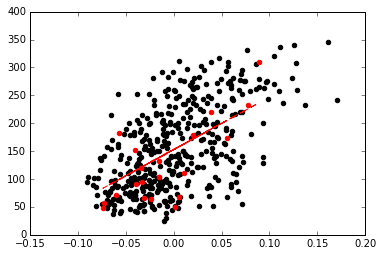

In [19]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Algorithm 3: Linear Regression - Conjugate Gradient (no regularization)

Problem with gradient descent: Takes very similar directions many times

Solution: Enforce conjugacy

`Step 1: Start with an initial point 
while(not converged) {
   Step 2: Compute gradient dw.
   Step 3: Compute stepsize alpha.
   Step 4: Compute next direction p by enforcing conjugacy with previous direction.
   Step 4: Update: w_new = w_old + alpha*p
}`

![Gradient Descent vs Conjugate Gradient](http://i.stack.imgur.com/zh1HH.png)


In [20]:
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    m = ncol(X); i = 1; 
    max_iter = 20;
    w = matrix (0, rows = m, cols = 1); # initialize weights to 0
    dw = - t(X) %*% y; p = - dw;        # dw = (X'X)w - (X'y)
    norm_r2 = sum (dw ^ 2); 
    for(i in 1:max_iter) {
        q = t(X) %*% (X %*% p)
        alpha = norm_r2 / sum (p * q);  # Minimizes f(w - alpha*r)
        w = w + alpha * p;              # update weights
        dw = dw + alpha * q;           
        old_norm_r2 = norm_r2; norm_r2 = sum (dw ^ 2);
        p = -dw + (norm_r2 / old_norm_r2) * p; # next direction - conjugacy to previous direction
        i = i + 1;
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [21]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.012 sec.
Number of executed Spark inst:	2.




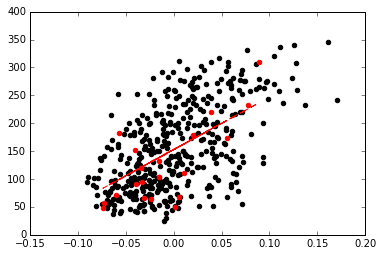

In [23]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Example 3: Invoke existing SystemML algorithm script LinearRegDS.dml using MLContext API

In [24]:
prog = dmlFromResource('scripts/algorithms/LinearRegDS.dml').input(X=diabetes_X_train, y=diabetes_y_train).input('$icpt',1.0).output('beta_out')
w = ml.execute(prog).get('beta_out')
w = w.toNumPy()
bias=w[1]

Computing the statistics...
Calling the Direct Solver...
BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
END LINEAR REGRESSION SCRIPT
Writing the output matrix...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,3.633533705616816E-14
STDEV_RES_Y,63.038506337610244
DISPERSION,3973.853281276927
R2,0.3351312506863875
ADJUSTED_R2,0.33354822985468835
R2_NOBIAS,0.3351312506863875
ADJUSTED_R2_NOBIAS,0.33354822985468835
SystemML Statistics:
Total execution time:		0.002 sec.
Number of executed Spark inst:	2.




In [ ]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w[0]*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Example 4: Invoke existing SystemML algorithm using scikit-learn/SparkML pipeline like API

*mllearn* API allows a Python programmer to invoke SystemML's algorithms using scikit-learn like API as well as Spark's MLPipeline API.

In [25]:
from pyspark.sql import SQLContext
from systemml.mllearn import LinearRegression
sqlCtx = SQLContext(sc)

In [26]:
regr = LinearRegression(sqlCtx)
# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

Running the CG algorithm...
BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
||r|| initial value = 64725.64237405237,  target value = 0.06472564237405237
Iteration 1:  ||r|| / ||r init|| = 0.013822097283108787
Iteration 2:  ||r|| / ||r init|| = 5.369915930350396E-14
Computing the statistics...
The CG algorithm is done.
END LINEAR REGRESSION SCRIPT
Writing the output matrix...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,-8.227243004822623E-12
STDEV_RES_Y,63.03850633759284
DISPERSION,3973.853281274733
PLAIN_R2,0.33513125068675453
ADJUSTED_R2,0.3335482298550564
PLAIN_R2_NOBIAS,0.33513125068675453
ADJUSTED_R2_NOBIAS,0.3335482298550564
SystemML Statistics:
Total execution time:		0.003 sec.
Number of executed Spark inst:	2.




lr

In [27]:
predictions = regr.predict(diabetes_X_test)

SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	1.




In [ ]:
# Use the trained model to perform prediction
%matplotlib inline
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, predictions, color='black')

# Uninstall/Clean up SystemML Python package and jar file